In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

# Pre-Trained : Image Classification :Production

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


In [2]:
!pip install torchmetrics --quiet

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms.functional import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import pandas as pd
import numpy as np
import os
import time
import json
import torchmetrics
import matplotlib.pyplot as plt
import copy

## Configurations

In [4]:
TRAIN_CSV = "/content/bean-leaf-lesions-classification/train.csv"
VAL_CSV = "/content/bean-leaf-lesions-classification/val.csv"

IMAGE_BASE_DIR = "/content/bean-leaf-lesions-classification/" # Directory containing the image folders ('train', 'val')

In [5]:
# Model & Training Settings
MODEL_NAME = "resnet18" # Options: "resnet18", "googlenet", "efficientnet_b0", etc.
FEATURE_EXTRACT = True # True: Freeze base model, train only classifier. False: Fine-tune all layers.
MODEL_SAVE_PATH = f"best_{MODEL_NAME}_feature_extract_{FEATURE_EXTRACT}.pth"
# LABEL_MAP_PATH = "bean_label_mapping.json" # No longer needed if labels are numerical
IMAGE_SIZE = 224 # Common size for ImageNet models (GoogLeNet might prefer 299)
BATCH_SIZE = 32
EPOCHS = 20 # Can increase if needed
LEARNING_RATE = 1e-3 if FEATURE_EXTRACT else 1e-4 # Lower LR for fine-tuning
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
EARLY_STOPPING_PATIENCE = 5

# Define image and label column names based on user's structure
IMAGE_COLUMN = "image:FILE"
LABEL_COLUMN = "category"

print(f"Using device: {DEVICE}")
print(f"Using model: {MODEL_NAME}")
print(f"Feature Extract Mode: {FEATURE_EXTRACT}")

Using device: cuda
Using model: resnet18
Feature Extract Mode: True


## 1. Data Loading and Preparation

In [6]:
def load_data_from_csv(csv_path, image_base_dir, image_col, label_col):
    """Loads image paths and numerical labels from a CSV file."""
    try:
        df = pd.read_csv(csv_path)
        # Check if required columns exist
        if image_col not in df.columns or label_col not in df.columns:
            raise ValueError(f"CSV must contain '{image_col}' and '{label_col}' columns.")

        # Construct full image path - assumes image_col contains relative paths from image_base_dir
        # If image_col already contains full paths, adjust this line or the IMAGE_BASE_DIR setting
        df['image_path'] = df[image_col].apply(lambda x: os.path.join(image_base_dir, x))

        # Rename the numerical label column to 'label_idx' for consistency
        df = df.rename(columns={label_col: 'label_idx'})

        # Ensure labels are integers
        if not pd.api.types.is_integer_dtype(df['label_idx']):
             try:
                 df['label_idx'] = df['label_idx'].astype(int)
             except ValueError:
                 raise ValueError(f"Column '{label_col}' could not be converted to integers.")

        # Check if paths exist (optional but recommended for robustness)
        # exist_mask = df['image_path'].apply(os.path.exists)
        # print(f"Found {exist_mask.sum()} existing images out of {len(df)} for {os.path.basename(csv_path)}")
        # df = df[exist_mask]

        if len(df) == 0:
             raise ValueError(f"No valid image paths found for {os.path.basename(csv_path)}.")

        return df
    except FileNotFoundError:
        raise ValueError(f"CSV file not found at {csv_path}")
    except Exception as e:
        raise RuntimeError(f"Error loading data from {csv_path}: {e}")

In [7]:
try:
    train_df_raw = load_data_from_csv(TRAIN_CSV, IMAGE_BASE_DIR, IMAGE_COLUMN, LABEL_COLUMN)
    val_df_raw = load_data_from_csv(VAL_CSV, IMAGE_BASE_DIR, IMAGE_COLUMN, LABEL_COLUMN)

    # Determine number of classes from the loaded data
    all_labels = pd.concat([train_df_raw['label_idx'], val_df_raw['label_idx']]).unique()
    num_classes = len(all_labels)
    if num_classes <= 1:
        raise ValueError("Detected only one or zero classes. Need at least two classes for classification.")
    print(f"Number of classes detected: {num_classes}")
    print(f"Detected class indices: {sorted(all_labels)}")

    # Assign directly as labels are already numerical indices
    train_df = train_df_raw
    val_df = val_df_raw

    # Optional: Save the number of classes if needed for inference structure
    # class_info = {'num_classes': num_classes}
    # with open("class_info.json", 'w') as f:
    #    json.dump(class_info, f)

    print(f"\nDataset loaded:")
    print(f"Train samples: {len(train_df)}")
    print(f"Train class distribution:\n{train_df['label_idx'].value_counts().sort_index()}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Validation class distribution:\n{val_df['label_idx'].value_counts().sort_index()}")
    # print(f"Test: {len(test_df)} samples") # If you create a test split

except ValueError as e:
    print(f"Data Loading Error: {e}")
    exit()
except RuntimeError as e:
    print(f"Data Loading Error: {e}")
    exit()

Number of classes detected: 3
Detected class indices: [np.int64(0), np.int64(1), np.int64(2)]

Dataset loaded:
Train samples: 1034
Train class distribution:
label_idx
0    341
1    345
2    348
Name: count, dtype: int64
Validation samples: 133
Validation class distribution:
label_idx
0    44
1    44
2    45
Name: count, dtype: int64


## 2. Define Transforms (Use standard ImageNet normalization)

In [8]:
# Pre-trained models expect specific normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float), # ToTensor already outputs float
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float),
    normalize
])

## 3. Custom Dataset

In [10]:
class LeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Store paths and labels directly
        self.image_paths = dataframe['image_path'].tolist()
        self.labels = dataframe['label_idx'].tolist() # Already numerical indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image file not found {img_path}. Skipping.")
            return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), -1 # Dummy return
        except Exception as e:
            print(f"Warning: Error opening image {img_path}: {e}. Skipping.")
            return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), -1

        if self.transform:
            image = self.transform(image)
        # Ensure label is returned as a long tensor for CrossEntropyLoss
        return image, torch.tensor(label, dtype=torch.long)

## 4. Create Datasets and DataLoaders

In [11]:
train_dataset = LeafDataset(train_df, transform=train_transform)
val_dataset = LeafDataset(val_df, transform=val_test_transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if DEVICE == "cuda" else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE == "cuda" else False)

## 5. Load Pre-trained Model and Modify Classifier

In [13]:
def get_pretrained_model(model_name, num_classes, feature_extract):
    """Loads a pretrained model and resets the final layer."""
    model_ft = None #Initailze model variable
    input_size = 0 #initilaze expected model input size variable

    weights_param = "IMAGENET1K_V1" # Default weights (trained on ImageNet)

    #---- Step 1 : Load the Base Pre-Trained Model -
    #Based on the model_name provided, load the corresponding architecture
    #with weights pre-trained on the large ImageNet dataset.
    if model_name == "resnet18":
      # Benefit: Loads a well-tested architecture with powerful features learned from millions of images.
        # Saves immense training time and data requirements compared to training from scratch.
        model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # --- Step 2 : Set Parameter Trainability (Feature Extraction vs. Fine-Tuning) ----
        if feature_extract:
          # Benefit (Feature Extraction): If True, freeze all layers of the pre-trained model.
            # Only the final, new classifier layer will be trained. Good for smaller datasets
            # or when the pre-trained features are highly relevant. Faster training, less VRAM needed.
            for param in model_ft.parameters():
                param.requires_grad = False #Freeze Parameters
        #---- Step 3 : Replace the Final Classifier Layer ----
        # Get the number of input features to the original final layer (called 'fc' in ResNet)
        num_ftrs = model_ft.fc.in_features
        # Create a *new* linear layer mapping those features to YOUR number of classes.
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        # Benefit: Adapts the model's output to match your specific problem (3 classes instead of ImageNet's 1000).

        input_size = 224 #Store the typical input size for this model

    #Similar setps for potentila models
    elif model_name == "googlenet":
        model_ft = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224 #GoogLeNet often uses 224, sometime 299

    elif model_name == "efficientnet_b0":
         model_ft = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
         if feature_extract:
             for param in model_ft.parameters():
                 param.requires_grad = False
         # EfficientNet's classifier is structured differently (a Sequential block usually)
         # We access the Linear layer inside it (often the last one, index [1])
         num_ftrs = model_ft.classifier[1].in_features
         model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
         # Benefit: Shows flexibility in adapting different model architectures.
         input_size = 224 #EfficientNet B0 default size

    #Step 4 : Handle the exception case
    else:
        raise ValueError(f"Model name '{model_name}' not recognized.")

    # Step 5: Ensure the NEW Classifier Layer IS Trainable (Crucial for Feature Extraction)
    if feature_extract:
         ## Check common names for the final layer ('fc' or 'classifier')
         if hasattr(model_ft, 'fc'):
             # Find the parameters of the *newly added* 'fc' layer and make them trainable.
             for param in model_ft.fc.parameters():
                 param.requires_grad = True
              # Benefit: Without this, NO parameters would be updated during training in feature extract mode.
         elif hasattr(model_ft, 'classifier') and isinstance(model_ft.classifier, nn.Sequential):
             # Handle cases like EfficientNet where 'classifier' might be Sequential or a single layer.
             for param in model_ft.classifier[-1].parameters():
                 # Assume the last layer in the sequence is the one we replaced.
                 param.requires_grad = True
         elif hasattr(model_ft, 'classifier'): # If classifier is just one layer
             for param in model_ft.classifier.parameters():
                 param.requires_grad = True

    # --- Step 6 : Informational Output ----
    #Print the input size the architecture was designed for.
    print(f"Model input size expected by architecture: {input_size}x{input_size}")
    #Comapre the IMAGE_SIZE used in transforms and warn if different
    if IMAGE_SIZE != input_size:
        print(f"Warning: Training with IMAGE_SIZE={IMAGE_SIZE} but model expects {input_size}.")

    # --- Step 7: Returen the Modified Model ---
    return model_ft

In [15]:
!pip install torchinfo --quiet

In [17]:
# --- step 8 : Initialze the model ----
# Call the function defined above with our specific configuration
model = get_pretrained_model(MODEL_NAME, num_classes, FEATURE_EXTRACT)
#Benefit : Created the ready to use model object based on our choices

# -- Step 9: Move Model to Device
#Transfer the model's parameters (weights) to the designated device (GPU or CPU).
model = model.to(DEVICE)
#Benefit:  Essential for leveraging GPU acceleration during training and inference.
print("\nModel loaded and modified.")

# ---Step 10: Print Model Summary (Optional)
try:
  # Use torchSummary to display the layers, output shapes, and parameter counts.
    from torchsummary import summary
    #IMPORTANT: Provide input_size WITHOUT the batch dimension (Channels, Height, Width)
    summary(model, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))
    # Benefit: Helps verify the architecture is correct and shows how many parameters
    # are trainable vs. non-trainable, confirming if feature extraction freezing worked.
except ImportError:
    print("\nInstall torchinfo for model summary: pip install torchsummary")
except Exception as e:
    print(f"\nCould not print model summary: {e}")

Model input size expected by architecture: 224x224

Model loaded and modified.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13    

## 6. Loss, Optimizer, Metrics

In [19]:
# --- Step 11: Set up Loss, Optimizer, Metrics ---
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification

params_to_update = model.parameters() # Default: all parameters
if FEATURE_EXTRACT:
    # Benefit: In feature extract mode, filter to ONLY update parameters where requires_grad=True
    # (which should only be the final classifier layer after Step 5).
    params_to_update = []
    print("\nParameters to train:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name) # Shows exactly which layer(s) are being trained
else:
    ## Benefit (Fine-tuning): If FEATURE_EXTRACT is False, all parameters remain trainable.
    print("\nTraining all model parameters (fine-tuning)...")

# Pass only the parameters needing updates to the optimizer.
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)
# Learning rate scheduler (optional but good practice)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# Metrics setup
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)


Parameters to train:
	 fc.weight
	 fc.bias


## 7. Training Loop (Similar structure to previous example)

In [20]:
# --- Step 12: Training Loop (and subsequent steps) ---
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}
best_val_acc = 0.0
best_model_wts = None
patience_counter = 0

print("\nStarting Training...")
start_time = time.time()

for epoch in range(EPOCHS): #Loop over the dataset multiple times
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train() #<<<< STEP 1
    running_train_loss = 0.0
    train_accuracy.reset() v## <<<<<< STEP 2

    # Loop over batches of data from the DataLoader
    for i, (inputs, labels) in enumerate(train_loader):
        # Filter invalid samples (if any from Dataset error handling)
        valid_indices = labels != -1
        if not valid_indices.all():
            inputs = inputs[valid_indices]
            labels = labels[valid_indices]
            if inputs.shape[0] == 0: continue #Skip empty batch

        ## Move data to the configured device (GPU or CPU)
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad() # <<<<<< STEP 4
        # Forward pass through the model
        if MODEL_NAME == "googlenet" and model.training:
            outputs = model(inputs).logits # <<<<<< STEP 5 (GoogLeNet specific)
        else:
            outputs = model(inputs) # <<<<<< STEP 5 (Standard)

        # Calculate the loss
        loss = criterion(outputs, labels) # <<<<<< STEP 6

        # Backpropagation
        loss.backward() # <<<<<< STEP 7

        # Update model weights
        optimizer.step() # <<<<<< STEP 8

        # --- Metric Calculation (for logging) ---
        running_train_loss += loss.item() * inputs.size(0) # <<<<<< STEP 9
        train_accuracy.update(outputs, labels) # <<<<<< STEP 10

    # Calculate average loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_dataset) # <<<<<< STEP 11
    epoch_train_acc = train_accuracy.compute() # <<<<<< STEP 12

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    val_accuracy.reset()

    with torch.no_grad():
        for inputs, labels in val_loader:
            valid_indices = labels != -1
            if not valid_indices.all():
                 inputs = inputs[valid_indices]
                 labels = labels[valid_indices]
                 if inputs.shape[0] == 0: continue

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            val_accuracy.update(outputs, labels)

    epoch_val_acc_float = 0.0
    if len(val_dataset) > 0:
        # Avoid division by zero if running_val_loss wasn't updated (e.g., all batches filtered)
        if running_val_loss > 0 or len(val_loader) > 0: # Check if validation ran
             epoch_val_loss = running_val_loss / len(val_dataset) # Divide by samples, not batches
        else:
             epoch_val_loss = 0.0

        epoch_val_acc = val_accuracy.compute()
        epoch_val_acc_float = epoch_val_acc.item()
    else:
        epoch_val_loss = 0.0

    # --- Logging & Saving ---
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc_float)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_duration:.2f}s] - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc.item():.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc_float:.4f}")

    scheduler.step(epoch_val_acc_float)

    if epoch_val_acc_float > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.4f} -> {epoch_val_acc_float:.4f}). Saving model...")
        best_val_acc = epoch_val_acc_float
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, MODEL_SAVE_PATH)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time:.2f}s")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Starting Training...
Epoch 1/20 [13.25s] - Train Loss: 0.9749, Train Acc: 0.5116 | Val Loss: 0.7426, Val Acc: 0.7218
Validation accuracy improved (0.0000 -> 0.7218). Saving model...
Epoch 2/20 [7.72s] - Train Loss: 0.6821, Train Acc: 0.7505 | Val Loss: 0.5722, Val Acc: 0.8195
Validation accuracy improved (0.7218 -> 0.8195). Saving model...
Epoch 3/20 [8.88s] - Train Loss: 0.5695, Train Acc: 0.8085 | Val Loss: 0.5079, Val Acc: 0.7669
Epoch 4/20 [8.78s] - Train Loss: 0.5186, Train Acc: 0.8046 | Val Loss: 0.4769, Val Acc: 0.8120
Epoch 5/20 [9.32s] - Train Loss: 0.4714, Train Acc: 0.8395 | Val Loss: 0.4285, Val Acc: 0.8271
Validation accuracy improved (0.8195 -> 0.8271). Saving model...
Epoch 6/20 [8.84s] - Train Loss: 0.4371, Train Acc: 0.8462 | Val Loss: 0.3742, Val Acc: 0.8496
Validation accuracy improved (0.8271 -> 0.8496). Saving model...
Epoch 7/20 [9.89s] - Train Loss: 0.4399, Train Acc: 0.8337 | Val Loss: 0.3313, Val Acc: 0.8947
Validation accuracy improved (0.8496 -> 0.8947). Sav

### Step-by-Step Explanation:

1. `model.train():`

* **What**: Sets the model to "training mode".

* **Under the Hood**: This tells certain layers, specifically **Dropout** and **BatchNorm2d**, to behave as they should during training. Dropout layers will randomly zero out activations, and BatchNorm layers will update their running statistics (mean and variance) based on the current batch.

* **Benefit**: Essential for proper training. Dropout helps prevent overfitting, and BatchNorm helps stabilize and speed up training. If you forget this, BatchNorm won't update its stats correctly, and Dropout won't be active.

2. `running_train_loss = 0.0, train_accuracy.reset():`

* **What**: Initializes variables to accumulate the loss and resets the **torchmetrics** accuracy object at the start of each epoch.

* **Benefit**: Ensures that the metrics calculated at the end of the epoch are only based on the current epoch's data.

3. `inputs, labels = inputs.to(DEVICE), labels.to(DEVICE):`

* **What**: Moves the batch of input images (`inputs`) and their corresponding labels (`labels`) from the CPU memory (where the DataLoader typically prepares them) to the target device (GPU, if available).

* **Benefit**: Crucial for performance. Model computations (especially matrix multiplications in linear and convolutional layers) are much faster on a GPU. The model itself is already on the device, so the data needs to be moved there too for the computation.

4. `optimizer.zero_grad():`

* **What**: Resets the gradients for all parameters that the optimizer is managing.

* **Under the Hood**: PyTorch accumulates gradients by default whenever `.backward()` is called. This means if you didn't zero them, gradients from previous batches would add up, leading to incorrect weight updates. This step explicitly sets the `.grad` attribute of all optimized parameters back to `None` or zero.

* **Benefit**: Ensures that the weight update (`optimizer.step()`) is based only on the error calculated from the current batch.

5. `outputs = model(inputs):`

* **What**: This is the **forward pass**. It feeds the input tensor (`inputs`) through the network layers defined in your `model`'s `forward` method.

* **Under the Hood**: Performs all the computations (convolutions, activations, pooling, linear transformations). The final output (`outputs`) for your classification model is a tensor of raw scores (logits), typically with a shape like [batch_size, num_classes] (e.g., [32, 3]).

* **GoogLeNet Specific**: GoogLeNet in training mode outputs an object containing the main `logits` and auxiliary logits. You only need the main `logits` for the primary loss calculation. In evaluation mode (`model.eval()`), it usually just returns the main logits directly.

* **Benefit**: Generates the model's predictions for the current batch.

6. `loss = criterion(outputs, labels):`

* **What**: Calculates the loss value by comparing the model's output logits (`outputs`) with the true labels (`labels`). You named your criterion `loss_fun`, but here it's called `criterion` – it's the same `nn.CrossEntropyLoss` object.

* Under the Hood (`nn.CrossEntropyLoss`):

  * It first applies a `LogSoftmax` function to the raw logits (`outputs`) to convert them into log-probabilities.

  * Then, it computes the Negative Log Likelihood Loss (`NLLLoss`) between these log-probabilities and the integer class labels (`labels`).

  * This combination is numerically more stable than applying `Softmax` yourself and then using `NLLLoss`.

* **Benefit**: Quantifies how "wrong" the model's predictions are for the current batch. A lower loss means better predictions. This scalar loss value is what drives the learning process.

7. `loss.backward():`

* **What**: Performs backpropagation.

* **Under the Hood**: This is where PyTorch's automatic differentiation engine (`Autograd`) shines. It computes the gradient of the scalar `loss` with respect to every model parameter (weights, biases) that has `requires_grad=True`. It uses the chain rule to propagate the error backward through the network layers. The computed gradients are stored in the `.grad` attribute of each parameter tensor.

* **Benefit**: Calculates the direction and magnitude of change needed for each parameter to reduce the loss.

8. `optimizer.step():`

* **What**: Updates all the model parameters based on the gradients computed in the `.backward()` step.

* **Under the Hood**: The optimizer (e.g., Adam) iterates through the parameters it was initialized with. For each parameter, it uses its `.grad` attribute, the learning rate (`LEARNING_RATE`), and its internal state (like momentum estimates in Adam) to calculate the updated value for the parameter.

* **Benefit**: This is the actual "learning" step where the model adjusts its weights to perform better on the task based on the error signal (loss).

9. `running_train_loss += loss.item() * inputs.size(0):`

* **What**: Accumulates the total loss for the epoch.

* **loss.item()**: Extracts the scalar loss value for the current batch from the loss tensor (which might be on the GPU) as a standard Python number (on the CPU).

* **inputs.size(0)**: Gets the actual number of samples in the current batch. This is usually BATCH_SIZE, but the last batch in an epoch might be smaller if the total dataset size isn't perfectly divisible by the batch size.

* **inputs.size(0)**: Multiplies the average loss for the batch (which `criterion` typically returns) by the number of items in the batch. This gives the total loss for the batch.

* **Benefit**: Accumulating the total batch losses allows you to calculate the correct average loss per sample over the entire epoch later (running_train_loss / len(train_dataset)), accurately accounting for potentially smaller final batches. If you just summed loss.item(), averaging by the number of batches would slightly underweight the contribution of the last batch if it was smaller.

10. `train_accuracy.update(outputs, labels):`

* **What**: Updates the `torchmetrics` accuracy object with the predictions (logits) and true labels for the current batch.

* **Under the Hood**: `torchmetrics` handles converting logits to predicted classes (using `argmax`) and compares them to the labels, keeping track of the counts internally.

* **Benefit**: Provides an efficient and reliable way to track accuracy across multiple batches.

11. `epoch_train_loss = running_train_loss / len(train_dataset):`

* **What**: Calculates the average training loss per sample for the entire epoch.

* **Benefit**: Provides a normalized metric to compare training performance across epochs or different training runs.

12. `epoch_train_acc = train_accuracy.compute():`

* **What**: Calculates the final accuracy over all batches processed by the train_accuracy object during the epoch.

* **Benefit**: Gives the overall training accuracy for the epoch.

## 8. Plot Training History

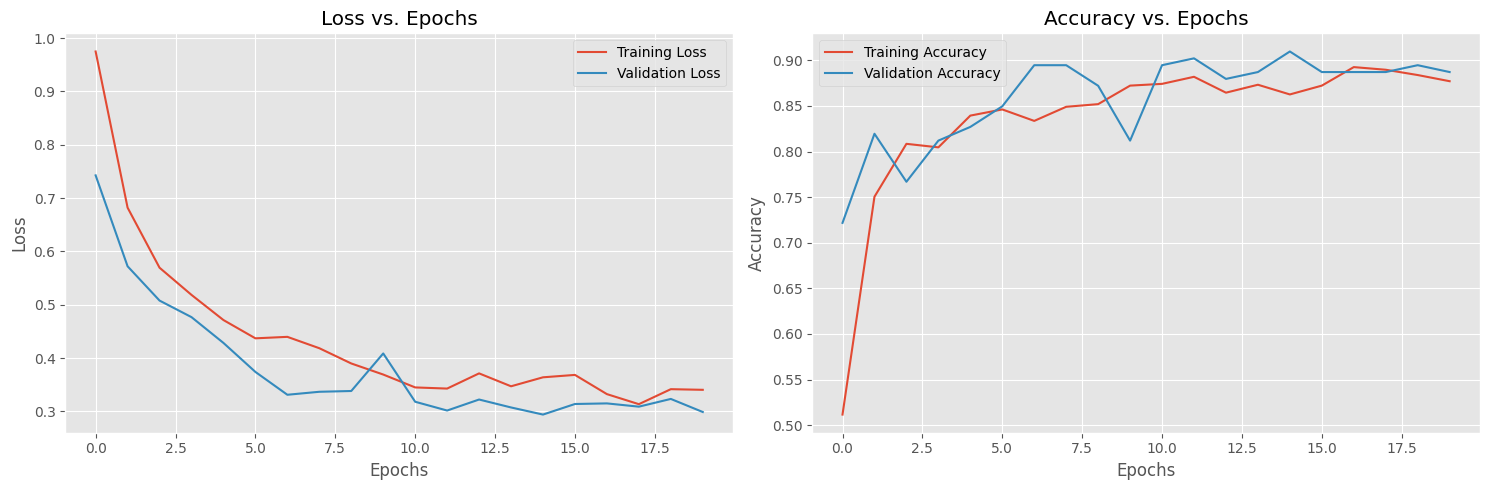

In [21]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history['train_loss'], label='Training Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss vs. Epochs'); axs[0].set_xlabel('Epochs'); axs[0].set_ylabel('Loss'); axs[0].legend()
axs[1].plot(history['train_acc'], label='Training Accuracy')
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Accuracy vs. Epochs'); axs[1].set_xlabel('Epochs'); axs[1].set_ylabel('Accuracy'); axs[1].legend()
plt.tight_layout(); plt.show()

## 9. Testing (Using Validation set as Test set here)

In [22]:
print("\nEvaluating on Validation/Test Set...")
if best_model_wts:
    model.load_state_dict(best_model_wts)
else:
    print("Warning: No best model weights found. Evaluating with final weights.")

model.eval()
test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader: # Using val_loader as test set
        valid_indices = labels != -1
        if not valid_indices.all():
             inputs = inputs[valid_indices]
             labels = labels[valid_indices]
             if inputs.shape[0] == 0: continue

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        test_accuracy.update(preds, labels)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

if len(val_dataset) > 0 and len(all_preds) > 0:
    final_test_acc = test_accuracy.compute()
    print(f"\nFinal Test Accuracy (on Val set): {final_test_acc.item():.4f}")
else:
     print("\nNo valid samples found or predicted in the validation set after filtering.")

if all_preds and all_labels:
    try:
        print("\nClassification Report (on Val set):")
        # Generate report using numerical labels directly
        print(classification_report(all_labels, all_preds, target_names=[str(i) for i in sorted(all_labels)]))
    except Exception as e:
        print(f"\nCould not generate classification report: {e}")
else:
     print("\nSkipping classification report.")


Evaluating on Validation/Test Set...

Final Test Accuracy (on Val set): 0.9098

Classification Report (on Val set):

Could not generate classification report: Number of classes, 3, does not match size of target_names, 133. Try specifying the labels parameter


## 10. Inference Function

In [23]:
def predict_transfer_learning_image(image_path, model_name, model_path, num_classes_inf, transform, device):
    """Loads a saved transfer learning model and predicts a single image."""
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Load model structure (needs to know num_classes)
        inf_model = get_pretrained_model(model_name, num_classes_inf, feature_extract=False)
        inf_model.load_state_dict(torch.load(model_path, map_location=device))
        inf_model = inf_model.to(device)
        inf_model.eval()

        # Predict
        with torch.no_grad():
            output = inf_model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_label_idx = predicted_idx.item() # Get the predicted index

        # Return the index and confidence
        return predicted_label_idx, confidence.item()

    except FileNotFoundError:
        return f"Error: File not found ({image_path} or {model_path}).", 0.0
    except Exception as e:
        return f"An error occurred during prediction: {e}", 0.0


In [24]:
example_img_path = "/content/bean-leaf-lesions-classification/val/healthy/healthy_val.0.jpg"

In [26]:
if os.path.exists(example_img_path) and os.path.exists(MODEL_SAVE_PATH):
    # Get num_classes from the trained model context
    predicted_class_idx, confidence_score = predict_transfer_learning_image(
        example_img_path,
        MODEL_NAME, # Pass the model name used for training
        MODEL_SAVE_PATH,
        num_classes, # Pass the number of classes used during training
        val_test_transform, # Use non-augmenting transforms
        DEVICE
    )
    print(f"\nInference on '{example_img_path}':")
    print(f"Predicted Class Index: {predicted_class_idx}")
    print(f"Confidence: {confidence_score:.4f}")
    # If you want to map index back to a name, you'd need to load/save that separately if needed
else:
    print(f"\nSkipping inference example: Required file(s) not found.")
    print(f"Check paths: {example_img_path}, {MODEL_SAVE_PATH}")

Model input size expected by architecture: 224x224

Inference on '/content/bean-leaf-lesions-classification/val/healthy/healthy_val.0.jpg':
Predicted Class Index: 0
Confidence: 0.4907
